# Kids First Development Analysis

Below is some statistics around code release and feature development over time in the Kids First Github organization.

In [1]:
import os
import requests
from dateutil.parser import parse
import re
import numpy as np
from collections import Counter
import matplotlib.dates as mdates
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
session = requests.Session()
session.headers.update({'Authorization': 'token '+os.environ['GH_TOKEN']})

In [3]:
repos = []
resp = session.get('https://api.github.com/orgs/kids-first/repos').json()
page = 1
while len(resp) > 0:
    page += 1
    repos.extend(resp)
    resp = session.get(f'https://api.github.com/orgs/kids-first/repos?page={page}').json()

In [4]:
def analyze_releases(repo):
    url = repo['releases_url'].format(**{'/id':''})
    releases = session.get(url).json()
    versions = [(parse(r['created_at']), r['tag_name']) for r in releases]
    return versions

IGNORE = [
    'kf-dictionary',
    'kf-es-model',
    'aws-ecs-service-type-1-module',
    'kf-key-management',
    'kf-arranger',
    'aws-infra-mongodb-module',
    'aws-infra-ec2-module',
    'kf-portal'
]

releases = {}

for repo in repos:
    if any([k in repo['name'] for k in IGNORE]):
        continue
    
    versions = analyze_releases(repo)
    if len(versions) > 1:
        releases[repo['name']] = np.array(versions)

In [5]:
def get_all_merges(repo):
    items = []
    page = 1
    resp = session.get(f'https://api.github.com/search/issues?q=is:merged+repo:kids-first/{repo}&page=1').json()
    while len(resp['items']) > 0:
        items.extend(resp['items'])
        page += 1
        resp = session.get(f'https://api.github.com/search/issues?q=is:merged+repo:kids-first/{repo}&page={page}').json()
    return items
    
    
merges = {}

for repo in releases.keys():
    ms = get_all_merges(repo)
    merges[repo] = ms

In [6]:
def plot_ts(r, title='Timeline', ax=None, start=None, stop=None):
    ax.plot((start, stop), (0, 0), 'k', alpha=.5)
    # Iterate through releases annotating each one
    for ii, (iname, idate) in enumerate(zip(r[:,0], r[:,1])):
        # level = levels[ii % 3]
        # vert = 'top' if level < 0 else 'bottom'
        ax.scatter(idate, 0, s=100, facecolor='w', edgecolor='k', zorder=9999)
        continue
        # If we want to annotate with text
        ax.plot((idate, idate), (0, level), c='r', alpha=.7)
        ax.text(idate, level, iname,
                horizontalalignment='right', verticalalignment=vert, fontsize=14,
                backgroundcolor=(1., 1., 1., .3))

    ax.set(title=title)
    ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=1))
    ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
    #ax.get_xaxis().set_minor_locator(mdates.DayLocator(interval=24))
    #ax.get_xaxis().set_minor_formatter(mdates.DateFormatter("%d"))
    plt.setp((ax.get_yticklabels() + ax.get_yticklines() +
              list(ax.spines.values())), visible=False)
    return ax

In [7]:
def ts_reg(df, forcast='30D'):
    last = df.index[-1]
    start = df.index[-1] - pd.Timedelta(forcast)
    X = mdates.date2num(pd.to_datetime(df[start:].index))

    mb = np.polyfit(X, df[df.index > start.isoformat()]['count'], 1)
    f = np.poly1d(mb)
    
    last = mdates.date2num(last + pd.Timedelta(forcast))
    start = mdates.date2num(start)
    
    #fig, cx = plt.subplots()
    fig = plt.gcf()
    cx = plt.gca()

    xx = np.linspace(start, last, 100)
    dd = mdates.num2date(xx)
    dd = [ d.replace(tzinfo=None) for d in dd ]
    
    plt.plot(dd, f(xx), '-g')
    df['count'].plot(style='x', ax=plt.gca())

In [8]:
df = pd.DataFrame.from_dict(repos)
df = df[['name', 'created_at']]
df = df.set_index('created_at')
df.index = pd.DatetimeIndex(df.index)
df['count'] = range(df.shape[0])

## Analysis of Number of Repositories

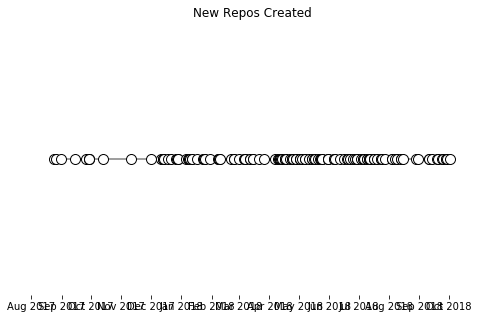

In [9]:
fig, ax = plt.subplots(figsize=(8, 5))
start = df.index[0]
stop = df.index[-1]

plot_ts(df.reset_index()[['name', 'created_at']].values, title='New Repos Created', ax=ax, start=start, stop=stop)
plt.show()

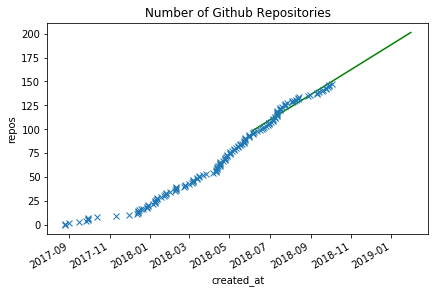

In [10]:
ts_reg(df, '120D')
plt.tight_layout()
plt.ylabel('repos')
plt.title('Number of Github Repositories')
plt.show()

## Analysis of Release Frequency

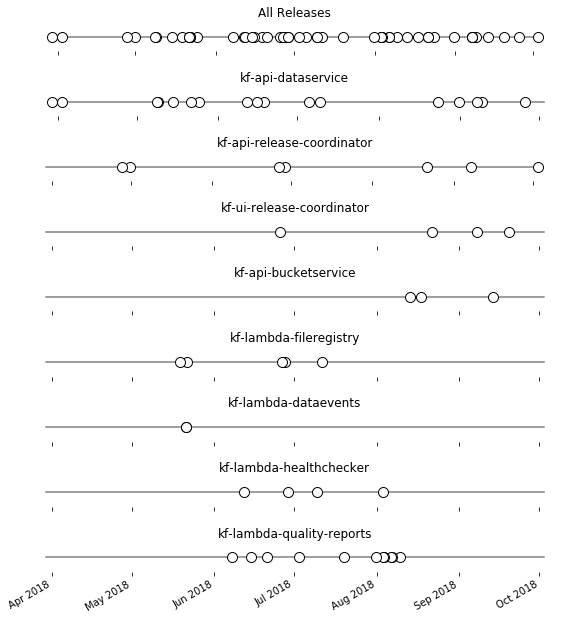

In [11]:
fig, ax = plt.subplots(figsize=(8, 10))
rs = []
mins = []
maxes = []
for release, dts in releases.items():
    rs.extend([list(r) for r in dts])
    mins.append(min([r[0] for r in dts]))
    maxes.append(max([r[0] for r in dts]))
start = min(mins)
stop = max(maxes)

rs = np.array(rs)
v = np.array([[v[1], pd.Timestamp(v[0].replace(tzinfo=None))] for v in rs])
ax = plt.subplot(len(releases)+1, 1, 1)
plot_ts(v, ax=ax, title='All Releases', start=start, stop=stop)

for i, (release, versions) in enumerate(releases.items()):
    ax = plt.subplot(len(releases)+1, 1, i+2)
    v = np.array([[v[1], pd.Timestamp(v[0].replace(tzinfo=None))] for v in versions])
    
    plot_ts(v, ax=ax, title=release, start=start, stop=stop)

plt.tight_layout()
fig.autofmt_xdate()
plt.show()

In [12]:
all_releases = {dt[0].replace(tzinfo=None): repo for repo, r in releases.items() for dt in r}
df = pd.DataFrame.from_dict(all_releases, orient='index')
df = df.rename({0: 'name'}, axis=1)
df.index = pd.DatetimeIndex(df.index)
df.index.name = 'created_at'
df = df.sort_index()
df['count'] = range(df.shape[0])

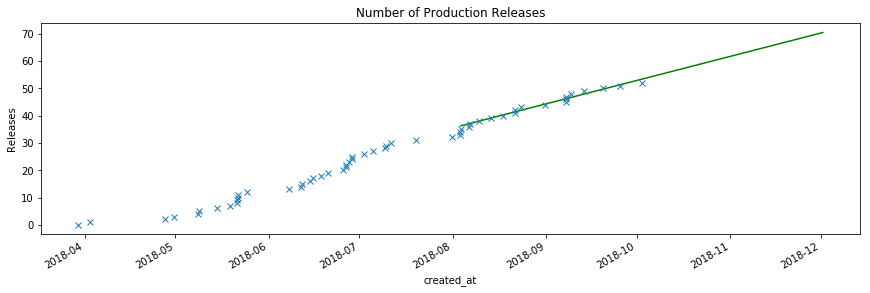

In [13]:
plt.figure(figsize=(12,4))
ts_reg(df, '60D')
plt.tight_layout()
plt.ylabel('Releases')
plt.title('Number of Production Releases')
plt.show()

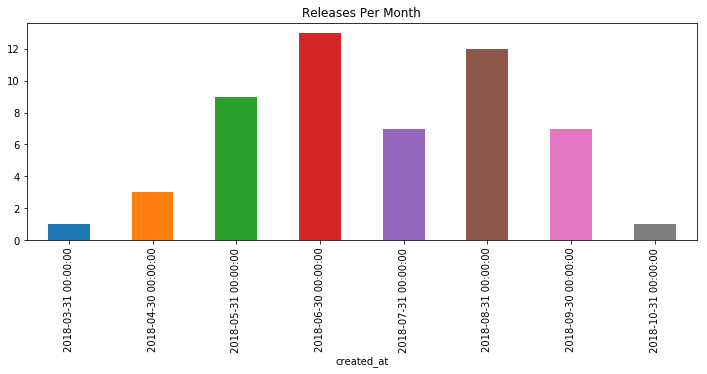

In [14]:
plt.figure(figsize=(12,4))
df.resample('1M').count()['count'].plot(kind='bar')
plt.title('Releases Per Month')
plt.show()

## Analysis of Pull Requests Merged

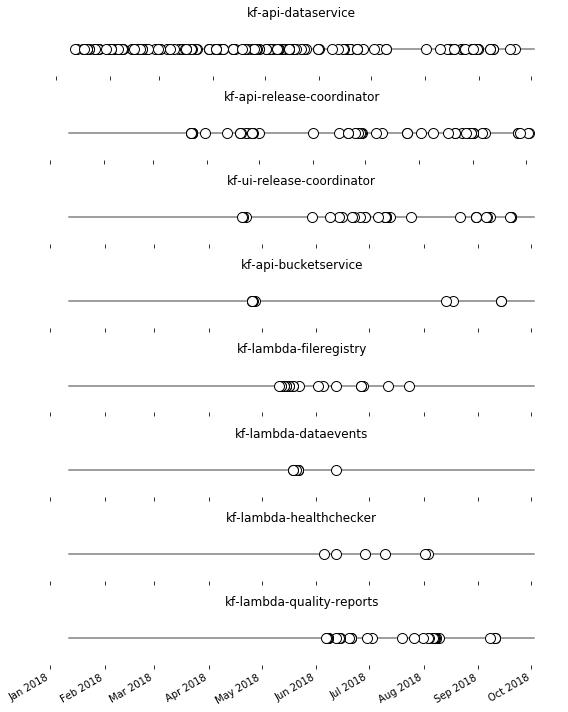

In [15]:
merges_by_date = {repo: [[parse(m['closed_at']), m['title']] for m in h] for repo, h in merges.items()}

fig, ax = plt.subplots(figsize=(8, 10))
mins = []
maxes = []
for merge, dts in merges_by_date.items():
    mins.append(min([r[0] for r in dts]))
    maxes.append(max([r[0] for r in dts]))
start = min(mins)
stop = max(maxes)

for i, (merge, versions) in enumerate(merges_by_date.items()):
    ax = plt.subplot(len(merges_by_date), 1, i+1)
    v = np.array([[v[1], pd.Timestamp(v[0].replace(tzinfo=None))] for v in versions])
    
    plot_ts(v, ax=ax, title=merge, start=start, stop=stop)

# plt.suptitle('Pull Requests Merged')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [16]:
all_merges = {dt[0].replace(tzinfo=None): repo for repo, r in merges_by_date.items() for dt in r}
df = pd.DataFrame.from_dict(all_merges, orient='index')
df = df.rename({0: 'name'}, axis=1)
df.index = pd.DatetimeIndex(df.index)
df.index.name = 'created_at'
df = df.sort_index()
df['count'] = range(df.shape[0])

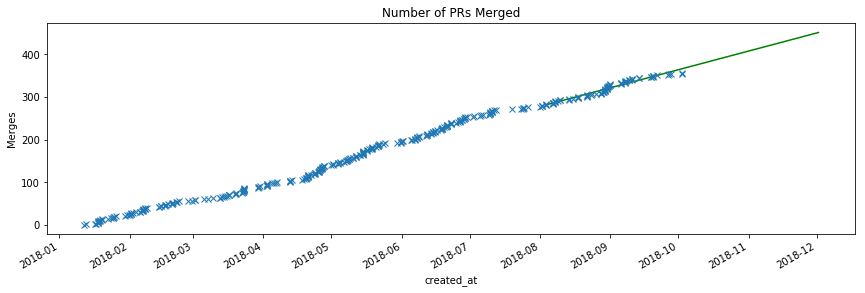

In [17]:
plt.figure(figsize=(12,4))
ts_reg(df, '60D')
plt.tight_layout()
plt.ylabel('Merges')
plt.title('Number of PRs Merged')
plt.show()